## Toxic Tweet Classification using LSTM (Long-Short Term Memory) with GloVe & Word2Vec embeddings.

In [40]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing required libraries.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Libraries for implementing LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization & word embeddings library
from collections import Counter
from gensim.models import Word2Vec

Importing tweets that were pre-processed earlier using various python libraries.

In [42]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/processed-tweets.csv', index_col=0)
data = data[data['Basic clean'].notna()]
print("Number of samples in data = "+str(len(data)))
data.head(20)

Number of samples in data = 44645


,Basic clean,sentiment,tweet_length
0,words katandandre food crapilicious mkr,not_cyberbullying,5
1,aussietv white mkr theblock today sunrise stud...,not_cyberbullying,10
2,classy whore red velvet cupcakes,not_cyberbullying,5
3,meh p thanks heads concerned another angry dud...,not_cyberbullying,9
4,isis account pretending kurdish account like i...,not_cyberbullying,8
5,yes test god good bad indifferent weird whatev...,not_cyberbullying,11
6,itu sekolah ya bukan tempat bully ga jauh kaya...,not_cyberbullying,10
7,karma hope bites kat butt nasty mkr,not_cyberbullying,7
8,everything mostly priest,not_cyberbullying,3
9,rebecca black drops school due bullying,not_cyberbullying,6


Assigning each class an integer value in the sentiment column and storing the sentiments in an array.

In [43]:
sentiments = ["religion", "age", "ethnicity", "gender", "not bullying", "other_cyberbullying"]
data['sentiment'] = data['sentiment'].replace({'religion':0, 'age':1, 'ethnicity':2, 'gender':3, 'not_cyberbullying':4, 'other_cyberbullying':5})
X = data['Basic clean']
Y = data['sentiment']

Defining a function to tokenize the column containing texts to a particular length.

In [44]:
def Tokenize(column, seq_len):
    # Creating a vocabulary of words from column
    corpus = [word for text in column for word in text.split()]  # List that contains all the words in the tweets
    count_words = Counter(corpus)  # Counter object stores the words as dictionary keys and their counts as values
    sorted_words = count_words.most_common()  # List which contains tuples and each tuple has (word, count) and they are sorted according to count values
    vocab_to_int = {word:i+1 for i, (word,c) in enumerate(sorted_words)}  # Creates a dictionary with keys as words and values as an integer value 

    # Tokenize the column's text using the vocabulary dictionary created above
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    
    # Add padding to tokens, each tokenized text is padded so that they have a length = seq_len
    text_tokens = np.zeros((len(text_int), seq_len), dtype = int)
    for i, token in enumerate(text_int):
        if len(token) <= seq_len:
            zeros = list(np.zeros(seq_len - len(token)))
            new_token = zeros + token
        else:
            new_token = token[: seq_len]
        text_tokens[i, :] = np.array(new_token)

    return vocab_to_int, text_tokens

In [45]:
max_len = np.max(data['tweet_length'])
vocabulary, tokenized_column = Tokenize(data['Basic clean'], max_len)
print("Total words in vocabulary = "+str(len(vocabulary)))
print(tokenized_column)

Total words in vocabulary = 45551
[[    0     0     0 ...   612 19727    25]
 [    0     0     0 ... 11316 19730   221]
 [    0     0     0 ...   857  9589  6775]
 ...
 [    0     0     0 ...   471 45551     3]
 [    0     0     0 ...    39     4    62]
 [    0     0     0 ...     8    29   217]]


Training word2vec embeddings.

In [46]:
word2vec_train_data = list(map(lambda x : x.split(), data['Basic clean']))
embedding_dim = 200
word2vec_model = Word2Vec(word2vec_train_data, size=embedding_dim)
Vocab_size = len(vocabulary)+1
print("Size of training data = "+str(len(word2vec_train_data)))

Size of training data = 44645


Creating an embedding matrix that will store embedding of each word in vocabulary. 

In [47]:
word2vec_embedding_matrix = np.zeros((Vocab_size, embedding_dim))  # Defining an embedding matrix for word2vec embeddings
for word, token in vocabulary.items():  # Filling the embedding matrix with word2vec trained embeddings
  if word2vec_model.wv.__contains__(word):
    word2vec_embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape = ", word2vec_embedding_matrix.shape)
print(word2vec_embedding_matrix)

Embedding Matrix Shape =  (45552, 200)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.44084239  0.6012603   0.01929741 ... -0.25910747  0.06569032
  -0.06478196]
 [-0.04002343 -0.31260291  0.04110106 ...  0.14214054 -0.00760728
   0.44697773]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


Installing GloVe python library.

In [48]:
! pip install glove-python-binary

Training GloVe embeddings.

In [49]:
tweet_text = []
tweet_sentiment = []
for key, value in data.iterrows():
  tweet = value['Basic clean'].split()
  tweet_text.append(tweet)
  tweet_sentiment.append(value['sentiment'])

In [50]:
from glove import Corpus, Glove

corpus = Corpus()  # Creating a corpus object that will generate the co-occurence matrix
corpus.fit(tweet_text, window = 10)  # Training the corpus to generate the co-occurence matrix that will be used by GloVe
glove = Glove(no_components=200, learning_rate=0.05)  # Creating a glove object that will use the matrix created above to create embeddings
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)  # Training glove to create embeddings
glove.add_dictionary(corpus.dictionary)  # Adding corpus dictionary to glove dictionary
glove.save('glove.model')  # Saving the model

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


Creating an embedding matrix to store glove embeddings.

In [51]:
glove_embedding_matrix = np.random.random((len(vocabulary)+1, embedding_dim))
count = 0
for word, token in vocabulary.items():
  embedding_vector = glove.word_vectors[glove.dictionary[word]]
  if embedding_vector is not None:
    count += 1
    glove_embedding_matrix[token] = embedding_vector
print("Completed!")
print("Number of words present in GloVe embeddings = "+str(count))

Completed!
Number of words present in GloVe embeddings = 45551


In [52]:
X = tokenized_column
Y = data['sentiment'].values

Performing stratified train-test split, using 70% for training set, 20% for test set and 10% for validation set.

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)  # train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)  # train-val split 

Performing random oversampling on the training data.

In [54]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train), np.array(y_train))  # Performing random oversampling

After performing oversampling, here we can see that each class has equal number of samples.

In [55]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5722],
       [   1, 5722],
       [   2, 5722],
       [   3, 5722],
       [   4, 5722],
       [   5, 5722]])

Converting training data, validation data and test data into tensor data set.

In [56]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

Using DataLoader so that we can pass the samples in minibatches and shuffle the data at every epoch to reduce model overfitting.

In [57]:
Batch_size = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=Batch_size, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=Batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=Batch_size, drop_last=True)

Defining the hyperparameters of the LSTM model.

In [58]:
num_classes = 6  # We are dealing with a multiclass classification problem of 6 classes
hidden_dim = 100  # Number of neurons of the internal state (internal neural network in the LSTM)
lstm_layers = 1  # Number of stacked LSTM layers
LR = 3e-4  # Learning rate
dropout = 0.5  # LSTM Dropout
bidirectional = True  # Boolean value to choose if to use a bidirectional LSTM or not
epochs = 5  # Number of training epochs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Defining a class for our neural network.

In [59]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        # EMBEDDING LAYER
        embedded = self.embedding(x)
        # LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        # Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        # FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(device)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(device)
        hidden = (h0, c0)
        return hidden

In [60]:
model = BiLSTM_Sentiment_Classifier(Vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional, Batch_size, dropout)  # Creating an object for the model
model = model.to(device)
model.embedding.weight.data.copy_(torch.from_numpy(glove_embedding_matrix)) # Initialize embedding with the previously defined embedding matrix
model.embedding.weight.requires_grad=True # Allowing our embedding matrix to be fined tuned to better adapt to our dataset and get higher accuracy
print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(45552, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [61]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [62]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

# lists to save the train and validation losses of every batch for each epoch
train_loss, valid_loss  = [], []
# lists to save the train and validation accuracy of every batch for each epoch
train_acc, valid_acc  = [], []

for e in range(epochs):

    # lists to save the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    # initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0

    model.train() 
    for inputs, labels in train_loader:  # Training the model
        inputs, labels = inputs.to(device), labels.to(device) # load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() # reset gradients 

        output, h = model(inputs,h) # get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) # get tensor of predicted values on the training set

        y_train_list.extend(y_pred_train.squeeze().tolist()) # transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() # count correctly classified texts per batch
        total += labels.size(0) # count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    # Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 # reset counter if validation accuracy increases

    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 # increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 80.968468).  Saving model ...
	Train_loss : 0.6511 Val_loss : 0.4513
	Train_acc : 75.055% Val_acc : 80.968%
Epoch 2:Validation accuracy increased (80.968468 --> 82.010135).  Saving model ...
	Train_loss : 0.5191 Val_loss : 0.4310
	Train_acc : 80.013% Val_acc : 82.010%
Epoch 3:Validation accuracy increased (82.010135 --> 82.423048).  Saving model ...
	Train_loss : 0.4342 Val_loss : 0.4248
	Train_acc : 83.511% Val_acc : 82.423%
Epoch 4:Validation accuracy increased (82.423048 --> 82.608390).  Saving model ...
	Train_loss : 0.3700 Val_loss : 0.4352
	Train_acc : 86.079% Val_acc : 82.608%
Epoch 5:Validation accuracy increased (82.608390 --> 82.652027).  Saving model ...
	Train_loss : 0.3198 Val_loss : 0.4489
	Train_acc : 88.061% Val_acc : 82.652%


[75.05538713 84.96968284 90.50839552 93.78206623 95.99172108]
[80.96846847 83.0518018  83.24887387 83.16441441 82.82657658]


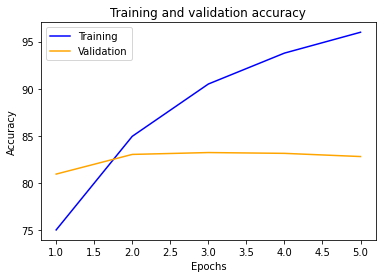

In [63]:
import matplotlib.pyplot as plt

xpoints = np.array([1, 2, 3, 4, 5])
ypoints_train = np.array(train_acc)
ypoints_val = np.array(valid_acc)
print(ypoints_train)
print(ypoints_val)
plt.plot(xpoints, ypoints_train, color="blue", label = "Training")
plt.plot(xpoints, ypoints_val, color="orange", label= "Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [64]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

Saving the models in google drive.

In [65]:
# model_save_name = 'LSTM-word2vec.pt'
model_save_name_1 = 'LSTM-GloVe.pt'

In [66]:
path = F"/content/gdrive/MyDrive/Colab Notebooks/{model_save_name_1}" 

In [67]:
torch.save(model.state_dict(), path)

In [68]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Running the models on test set.

In [69]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    test_h = model.init_hidden(labels.size(0))
    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [70]:
from sklearn.metrics import classification_report
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
                      precision    recall  f1-score   support

           religion       0.94      0.94      0.94      1590
                age       0.96      0.98      0.97      1579
          ethnicity       0.97      0.98      0.97      1548
             gender       0.81      0.87      0.84      1523
       not bullying       0.65      0.54      0.59      1529
other_cyberbullying       0.56      0.61      0.58      1159

           accuracy                           0.83      8928
          macro avg       0.82      0.82      0.82      8928
       weighted avg       0.83      0.83      0.83      8928

